### Analyzing the careful attack in practice




In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [2]:
RESULTS_LOCATION  = '../../../../data/results/'
IMG_LOCATION = '../images/'

In [3]:
RESULTS_FILES = [('careful_iterations=887_samples=900083_scalefunc=K_0_delta=500_centroids=346_sizeBytes=5568_impl=merging_alt_false.csv', {'TD abs. error':'Merging (alt=false)'}),
  ('careful_iterations=890_samples=2413634_scalefunc=K_0_delta=500_centroids=350_sizeBytes=4232_impl=tree.csv', {'TD abs. error': 'Clustering'}),
 ('careful_iterations=889_samples=1038262_scalefunc=K_0_delta=500_centroids=348_sizeBytes=5600_impl=merging_alt_true.csv',  {'TD abs. error': 'Merging (alt=true)'})]




In [4]:
class TDigestComparisonPlot(object):
    
    def __init__(self, f, plot_name=None):
        self.filename = f
        self.plot_name = plot_name
        
    def readable_name(self):
        return self.filename.rstrip('.csv').split('=')[-1]

    def _set_df(self):
        with open(RESULTS_LOCATION + self.filename, 'r') as f:
            self.df = pd.read_csv(f, header=0, sep=';')
        
    def plot_data(self, column_range=(1, -1), use_col=True, use_readable=True):
        self._set_df()
        # TODO: add KLL columns
        x_axis = self.df.columns[0]
        for col in self.df.columns[column_range[0] : column_range[1]]:
            if self.plot_name is not None:
                l = self.plot_name[col]
            else:
                l = ''
                if use_col is True:
                    l += col
                if use_readable is True:
                    l+= self.readable_name()
            #label = col + self.readable_name() if use_col is True else self.readable_name() 
            plt.plot(self.df[x_axis], self.df[col], label=l)
        #plt.plot(self.df['true quantile'][:200], self.df[self.error][:200], label=self.readable_name())
        
        

In [5]:
SORTED_RESULTS_FILES = ['careful_iterations=887_samples=900083_scalefunc=K_0_delta=500_centroids=304_sizeBytes=4896_impl=merging_alt_false_sorted.csv',
'careful_iterations=889_samples=1038262_scalefunc=K_0_delta=500_centroids=307_sizeBytes=4944_impl=merging_alt_true_sorted.csv',
'careful_iterations=890_samples=2413634_scalefunc=K_0_delta=500_centroids=315_sizeBytes=3812_impl=tree_sorted.csv']

In [6]:
def display(res_files, places=0, column_range=(1,-1), imgname=None, xlabel='quantile', ylabel='error',
           use_col=True, title=None, use_readable=True, xlim=None, ylim=None):
    digests = [TDigestComparisonPlot(f[0], plot_name=f[1]) for f in res_files]
    for t in digests:
        t.plot_data(column_range=column_range, use_col=use_col, use_readable=use_readable)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    f = lambda x : ('{:.' + str(places) + 'f}%').format(x*100) 
    plt.gca().set_yticklabels([f(x) for x in plt.gca().get_yticks()]) 
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if imgname is not None:
        plt.savefig(IMG_LOCATION + 'plot_' + imgname + '.png', dpi=300)
    plt.show()


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


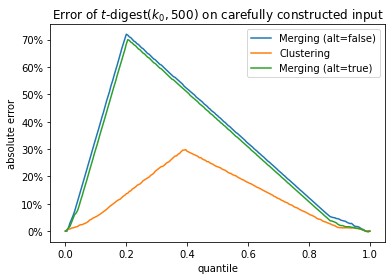

In [7]:
display(RESULTS_FILES, ylabel='absolute error', column_range=(1, 2), use_col=False,
        title='Error of $t$-digest$(k_0, 500)$ on carefully constructed input',
        imgname='careful_input_three_digests')

Sorting the same adversarial stream means the centroids should be strongly ordered, and indeed the error is much smaller when the input is presented to the $t$-digest in sorted order. Note the KLL bands are essentially the same in the scenarios above (omitted since scales disparate).

The plots corresponding to the other t-digest parameters are similar.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


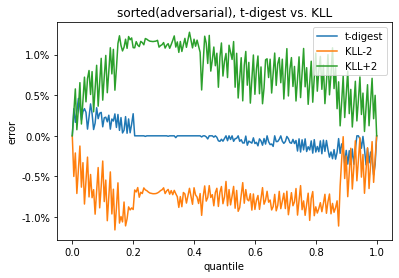

In [8]:
#true quantile;'TD abs. error';kll -2SD error; kll +2SD error;item

display([(SORTED_RESULTS_FILES[1], {'TD abs. error':'t-digest',
                                   'kll -2SD error': 'KLL-2',
                                   ' kll +2SD error': 'KLL+2'})], places=1, column_range=(1, -1),
       title='sorted(adversarial), t-digest vs. KLL')

### Local overlap computation

Given a $t$-digest $\{ C_1, \ldots, C_n \}$, we compute the function mapping a centroid $C_i$ to the Kolmogorov-Smirnov statistic of the sets underlying $C_i$ and $C_{i+1}$, i.e., a measure of the overlap between neighborhood centroids. The K-S statistic ranges from $0$ (limit of the completely mixed case) to $1$ (completely separated case), and we may view a centroid as occupying an interval quantile space, hence the mapping may be viewed as a function from the unit interval to itself.

In [9]:
class CentroidOverlapComputation(object):
    
    def __init__(self, f):
        self.filename = f
        
    def readable_name(self):
        return self.filename.rstrip('.csv').split('=')[-1]
    
    def _get_counts(self):
        with open(RESULTS_LOCATION + self.filename, 'r') as f:
            self.centroids = [[float(y) for y in line.rstrip('\n').split(',') if len(y) > 0] for line in f.readlines()]
        
    def _verify_total_count(self):
        self.counts = [len(x) - 1 for x in self.centroids]
        self.total_count = sum(self.counts)
        assert('samples={}'.format(self.total_count) in self.filename)

    def _compute_ks_stats(self):
        self.ks = []
        for idx in range(len(self.centroids) - 1):
            centroid = self.centroids[idx][1:]
            next_centroid = self.centroids[idx + 1][1:]
            self.ks.append(ks_2samp(centroid, next_centroid)[0])

    def _compute_cum_norm_weight(self):
        q = [count / self.total_count for count in self.counts]
        self.cum_weight = [sum(q[:i + 1]) for i in range(len(q))]
        
    def plot(self):
        assert(len(self.ks) == len(self.cum_weight) - 1)
        plt.plot(self.cum_weight[:-1], self.ks, label=self.readable_name())
        
    def prepare(self):
        self._get_counts()
        self._verify_total_count()
        self._compute_ks_stats()
        self._compute_cum_norm_weight()

In [10]:
def display_ks_curves(res_files, title=None, imgname=None):
    cents = [CentroidOverlapComputation(f) for f in res_files]
    for c in cents:
        c.prepare()
        c.plot()
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.xlabel('cumulative centroid weight')
    plt.ylabel('local KS statistic')
    if imgname is not None:
        plt.savefig(IMG_LOCATION + 'plot_' + imgname + '.png', dpi=300)
    plt.show()

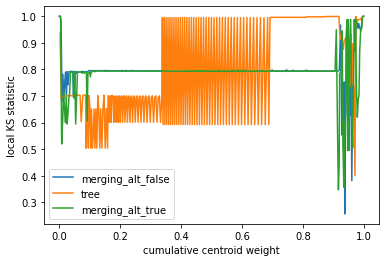

In [22]:
display_ks_curves(['centroids_' + x for x in [y[0] for y in RESULTS_FILES]])

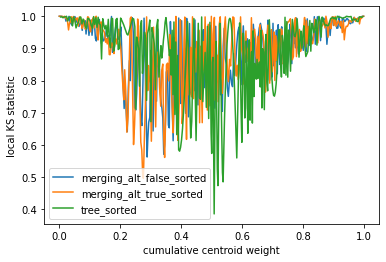

In [23]:
display_ks_curves(['centroids_' + x for x in SORTED_RESULTS_FILES])

In [13]:
iid_data = [x for x in os.listdir(RESULTS_LOCATION) if x.startswith('iid_20210204') and x.endswith('.csv')]

In [14]:
iid_data

['iid_20210204_165203_loguniform_lgN=20_lgT=12_Merging_compr=500_K_2_GLUED.csv',
 'iid_20210204_165114_loguniform2_lgN=20_lgT=12_Merging_compr=500_K_2_GLUED.csv',
 'iid_20210204_165301_loguniform2_lgN=20_lgT=12_maxExp=10_AVLTree_compr=500_K_2_GLUED.csv',
 'iid_20210204_165325_loguniform_lgN=20_lgT=12_AVLTree_compr=500_K_2_GLUED.csv',
 'iid_20210204_165313_loguniform2_lgN=20_lgT=12_AVLTree_compr=500_K_2_GLUED.csv',
 'iid_20210204_165233_loguniform2_lgN=20_lgT=12_maxExp=10_Merging_compr=500_K_2_GLUED.csv']

In [15]:
#true quantile;'TD abs. error';kll -2SD error; kll +2SD error;item
['iid_20210204_165301_loguniform2_lgN=20_lgT=12_maxExp=10_AVLTree_compr=500_K_2_GLUED.csv',
'iid_20210204_165233_loguniform2_lgN=20_lgT=12_maxExp=10_Merging_compr=500_K_2_GLUED.csv']
{'TD abs. error':'t-digest', 'kll -2SD error': 'KLL-2', ' kll +2SD error': 'KLL+2'}

{'TD abs. error': 't-digest',
 'kll -2SD error': 'KLL-2',
 ' kll +2SD error': 'KLL+2'}

In [16]:
[x for x in iid_data if 'maxExp=10_AVLTree' in x]

['iid_20210204_165301_loguniform2_lgN=20_lgT=12_maxExp=10_AVLTree_compr=500_K_2_GLUED.csv']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


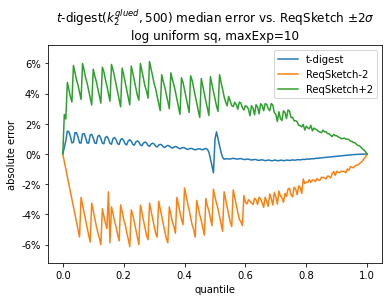

In [17]:
#true quantile;t-digest median error;ReqSketch -2SD error;ReqSketch +2SD error;item

display([('iid_20210204_165301_loguniform2_lgN=20_lgT=12_maxExp=10_AVLTree_compr=500_K_2_GLUED.csv',
        {'t-digest median error':'t-digest', 'ReqSketch -2SD error': 'ReqSketch-2', 'ReqSketch +2SD error': 
         'ReqSketch+2'})],
        title='$t$-digest$(k_2^{glued}, 500)$ median error vs. ReqSketch $\pm 2 \sigma$\nlog uniform sq, maxExp=10',
        ylabel='absolute error', use_readable=False, ylim=(-.072, .072), imgname='log_uniform2_maxExp10_td_v_Req')


#results for Merging are similar, omitted for clarity

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


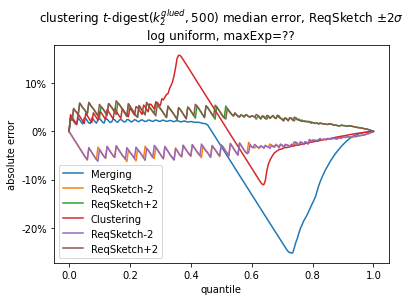

In [18]:
log_unif = [('iid_20210204_165203_loguniform_lgN=20_lgT=12_Merging_compr=500_K_2_GLUED.csv', {'t-digest median error':'Merging', 'ReqSketch -2SD error': 'ReqSketch-2', 'ReqSketch +2SD error': 'ReqSketch+2'}),
('iid_20210204_165325_loguniform_lgN=20_lgT=12_AVLTree_compr=500_K_2_GLUED.csv', {'t-digest median error':'Clustering', 'ReqSketch -2SD error': 'ReqSketch-2', 'ReqSketch +2SD error': 'ReqSketch+2'})]


display(log_unif,
        title='clustering $t$-digest$(k_2^{glued}, 500)$ median error, ReqSketch $\pm 2 \sigma$\nlog uniform, maxExp=??',
        ylabel='absolute error', use_readable=False, imgname='log_uniform_maxExp?_td_v_Req')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


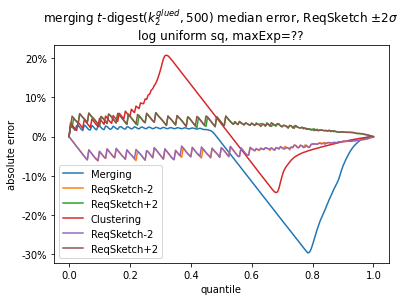

In [19]:
log_unif_sq = [('iid_20210204_165114_loguniform2_lgN=20_lgT=12_Merging_compr=500_K_2_GLUED.csv', {'t-digest median error':'Merging', 'ReqSketch -2SD error': 'ReqSketch-2', 'ReqSketch +2SD error': 'ReqSketch+2'}),
('iid_20210204_165313_loguniform2_lgN=20_lgT=12_AVLTree_compr=500_K_2_GLUED.csv', {'t-digest median error':'Clustering', 'ReqSketch -2SD error': 'ReqSketch-2', 'ReqSketch +2SD error': 'ReqSketch+2'})]



display(log_unif_sq,
        title='merging $t$-digest$(k_2^{glued}, 500)$ median error, ReqSketch $\pm 2 \sigma$\nlog uniform sq, maxExp=??',
        ylabel='absolute error', use_readable=False, imgname='log_uniform_sq_maxExp?_td_v_Req')